In [1]:
import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np
from collections import Counter
from data_science_toolkit.data_visualization import get_fig_ax, visualize_class_distribution, top_n_tokens_plot_from_counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

In [2]:
output_col = 'above_monthly_avg'

In [3]:
%matplotlib inline
# %matplotlib notebook
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

In [80]:
stop_words = set(stopwords.words('english')).union({'', 'would'})
# , '-', '&', '"', ':', '/'

In [79]:
stop_words

{'',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own'

In [5]:
file_name = 'trump_tweets_sp500.csv'
stock_tweet = pd.read_csv('./stocks/{}'.format(file_name))
stock_tweet['created_at']= pd.to_datetime(stock_tweet['created_at']) 

In [6]:
stock_tweet.head(10)

,text,created_at,retweet_count,favorite_count,is_retweet,after_dir,1_open_dir,1_close_dir,2_open_dir,2_close_dir,...,sow_open_dir,sig_up,sig_down,is_sig,preprocessed_text,created_hour,dow,num_links,num_words,above_monthly_avg
0,Celebrity Apprentice returns to NBC Sunday 3/14 9-11PM ET/PT. Outstanding list of celebrities & season should be the best one yet!,2010-01-12 18:05:08,20.0,3,False,1,1,1,1,0,...,0,0,0,0,celebrity apprentice returns to nbc sunday 3/14 9-11pm et/pt . outstanding list of celebrities & season should be the best one yet !,18,1,0,20,0
1,Trump Tycoon App for iPhone & iPod Touch - It's $2.99 but the advice is priceless! http://bit.ly/UGUF0,2010-01-15 16:28:02,23.0,20,False,0,0,1,1,0,...,0,0,1,1,trump tycoon app for iphone & ipod touch - it 's $ 2.99 but the advice is priceless ! msciurl,16,4,1,15,0
2,"from Donald Trump: ""I saw Lady Gaga last night and she was fantastic!""",2010-01-21 16:58:43,3813.0,3223,False,0,0,0,0,0,...,0,0,1,1,from donald trump : `` i saw lady gaga last night and she was fantastic ! '',16,3,0,14,1
3,Golf Channel & Donald Trump's World of Golf host a Celebrity Match 1/25 @ TNGC LA CA - Mark Wahlberg vs. Kevin Dillon http://bit.ly/4MubN6,2010-01-22 20:51:00,12.0,1,False,1,1,1,1,1,...,0,0,0,0,golf channel & donald trump 's world of golf host a celebrity match 1/25 @ tngc la ca - mark wahlberg vs. kevin dillon msciurl,20,4,1,20,0
4,Superbowl Sunday is a great American tradition. The Colts and Saints are already champions but may the best team win!,2010-02-07 16:54:42,16.0,3,False,0,0,1,1,1,...,1,0,0,0,superbowl sunday is a great american tradition . the colts and saints are already champions but may the best team win !,16,6,0,19,0
5,Donald Trump appearing today on CNN International’s ‘Connect the World’ as ‘Connector of the Day’. Submit questions: http://bit.ly/bPiP7T,2010-02-10 15:17:56,7.0,1,False,0,0,1,1,1,...,1,0,0,0,donald trump appearing today on cnn international ' s ' connect the world ' as ' connector of the day ' . submit questions : msciurl,15,2,1,17,0
6,Donald Trump appeared on the final episode of The Jay Leno Show to deliver a very special message: http://bit.ly/cv1En7,2010-02-11 19:57:36,16.0,3,False,0,1,1,1,1,...,1,0,0,0,donald trump appeared on the final episode of the jay leno show to deliver a very special message : msciurl,19,3,1,17,0
7,From Donald Trump: “I’m so proud of my wife Melania and the launch of her new jewelry line to debut on QVC on April 30th at 9 p.m.”,2010-02-26 21:18:26,25.0,21,False,1,1,1,1,1,...,1,0,0,0,"from donald trump : "" i ' m so proud of my wife melania and the launch of her new jewelry line to debut on qvc on april 30th at 9 p.m . """,21,4,0,26,1
8,From Donald Trump: Andrea Bocelli @ Mar-a-Lago - Many say best night of entertainment in long history of Palm Beach http://bit.ly/2fNgOz,2010-03-05 14:51:32,7.0,6,False,1,1,1,1,1,...,1,1,0,1,from donald trump : andrea bocelli @ mar-a-lago - many say best night of entertainment in long history of palm beach msciurl,14,4,1,18,0
9,The Celebrity Apprentice has a two-hour premiere this Sunday March 14th at 9 p.m. on NBC. This will be the best season yet see you then!,2010-03-12 20:30:52,23.0,7,False,0,1,1,1,1,...,1,0,0,0,the celebrity apprentice has a two-hour premiere this sunday march 14th at 9 p.m. on nbc . this will be the best season yet see you then !,20,4,0,24,1


In [7]:
since_election = stock_tweet[stock_tweet["created_at"] > datetime(2016, 11, 8)]

# 1.0 Class Distribution

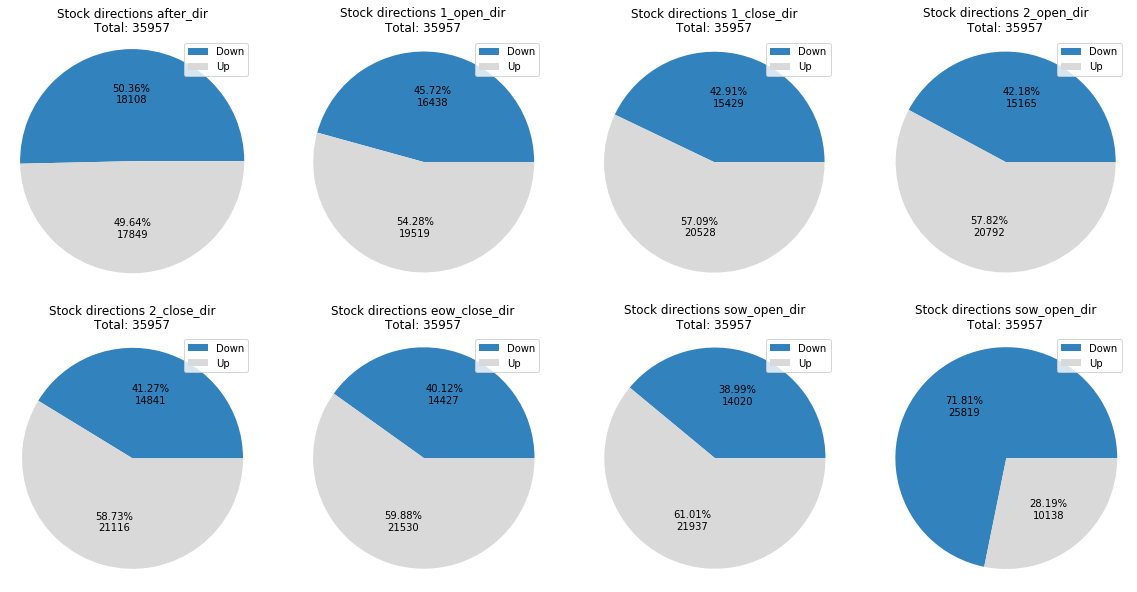

In [8]:
fig, ax = get_fig_ax(2, 4, 5, 5)
ax = visualize_class_distribution(stock_tweet["after_dir"], given_title="Stock directions after_dir", given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=0, col_idx=0)
ax = visualize_class_distribution(stock_tweet["1_open_dir"], given_title="Stock directions 1_open_dir", given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=0, col_idx=1)
ax = visualize_class_distribution(stock_tweet["1_close_dir"], given_title="Stock directions 1_close_dir", given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=0, col_idx=2)
ax = visualize_class_distribution(stock_tweet["2_open_dir"], given_title="Stock directions 2_open_dir", given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=0, col_idx=3)
ax = visualize_class_distribution(stock_tweet["2_close_dir"], given_title="Stock directions 2_close_dir", given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=1, col_idx=0)
ax = visualize_class_distribution(stock_tweet["eow_close_dir"], given_title="Stock directions eow_close_dir", given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=1, col_idx=1)
ax = visualize_class_distribution(stock_tweet["sow_open_dir"], given_title="Stock directions sow_open_dir", given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=1, col_idx=2)
ax = visualize_class_distribution(stock_tweet[output_col], given_title="Stock directions sow_open_dir", given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=1, col_idx=3)

## 1.1 Class Distribution since Election

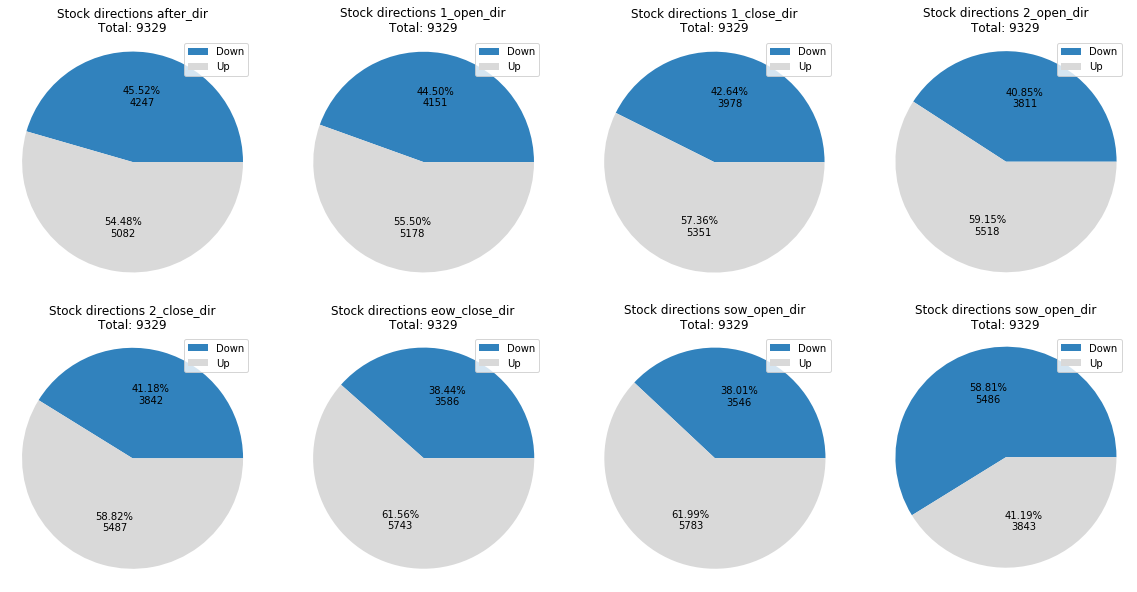

In [9]:
fig, ax = get_fig_ax(2, 4, 5, 5)
ax = visualize_class_distribution(since_election["after_dir"], given_title="Stock directions after_dir", given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=0, col_idx=0)
ax = visualize_class_distribution(since_election["1_open_dir"], given_title="Stock directions 1_open_dir", given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=0, col_idx=1)
ax = visualize_class_distribution(since_election["1_close_dir"], given_title="Stock directions 1_close_dir", given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=0, col_idx=2)
ax = visualize_class_distribution(since_election["2_open_dir"], given_title="Stock directions 2_open_dir", given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=0, col_idx=3)
ax = visualize_class_distribution(since_election["2_close_dir"], given_title="Stock directions 2_close_dir", given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=1, col_idx=0)
ax = visualize_class_distribution(since_election["eow_close_dir"], given_title="Stock directions eow_close_dir", given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=1, col_idx=1)
ax = visualize_class_distribution(since_election["sow_open_dir"], given_title="Stock directions sow_open_dir", given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=1, col_idx=2)
ax = visualize_class_distribution(since_election[output_col], given_title="Stock directions sow_open_dir", given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=1, col_idx=3)

# 2.0 Most Common Words

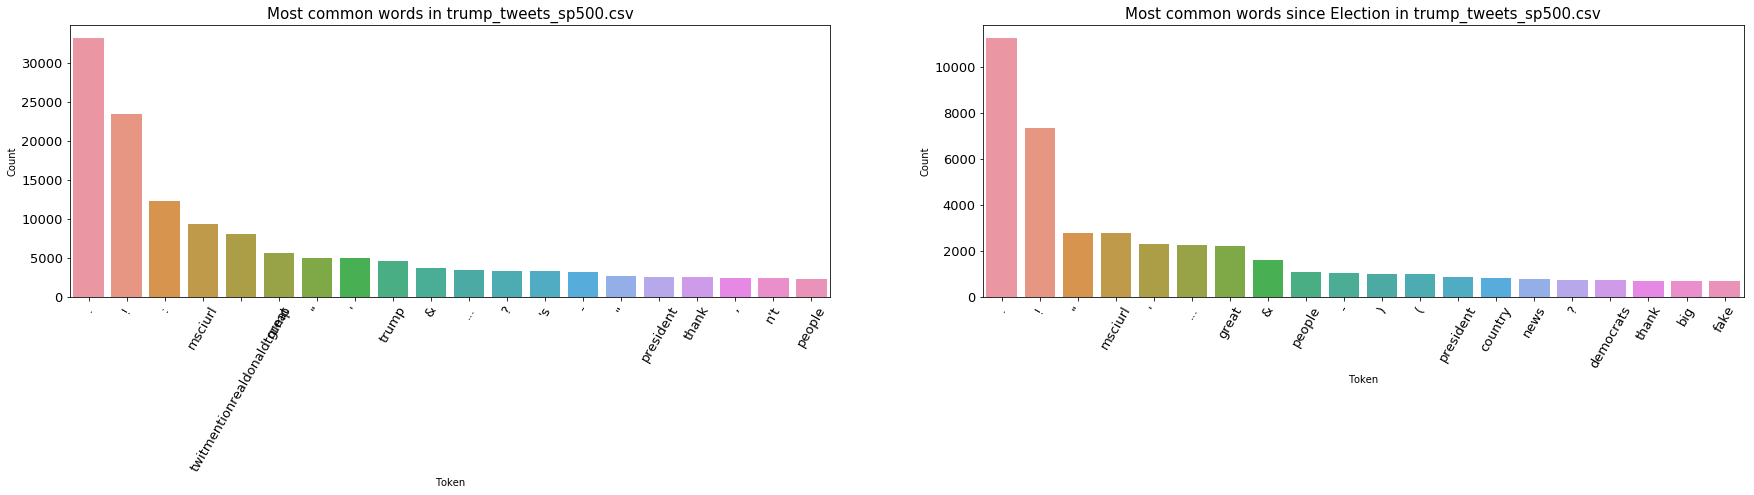

In [10]:
fig, ax = get_fig_ax(1, 2, 15, 5)
ax = top_n_tokens_plot_from_counter(Counter([x for x in ' '.join(stock_tweet["preprocessed_text"].tolist()).split(" ") if x not in stop_words]), 20, ax, 0, 0, "Most common words in {}".format(file_name))
ax = top_n_tokens_plot_from_counter(Counter([x for x in ' '.join(since_election["preprocessed_text"].tolist()).split(" ") if x not in stop_words]), 20, ax, 0, 1, "Most common words since Election in {}".format(file_name))

## 2.1 Most Common Words (Up/Unchanged vs Down)

In [11]:
up_tweet = stock_tweet[stock_tweet[output_col] == 1]
up_since_election = since_election[since_election[output_col] == 1]
down_tweet = stock_tweet[stock_tweet[output_col] == 0]
down_since_election = since_election[since_election[output_col] == 0]

In [12]:
def get_count_no_sw(df):
    return Counter([x for x in ' '.join(df["preprocessed_text"].tolist()).split(" ") if x not in stop_words])

In [13]:
up_not_down = get_count_no_sw(up_tweet) - get_count_no_sw(down_tweet)
up_not_down_since_election = get_count_no_sw(up_since_election) - get_count_no_sw(down_since_election)
down_not_up = get_count_no_sw(down_tweet) - get_count_no_sw(up_tweet)
down_not_up_since_election = get_count_no_sw(down_since_election) - get_count_no_sw(up_since_election)

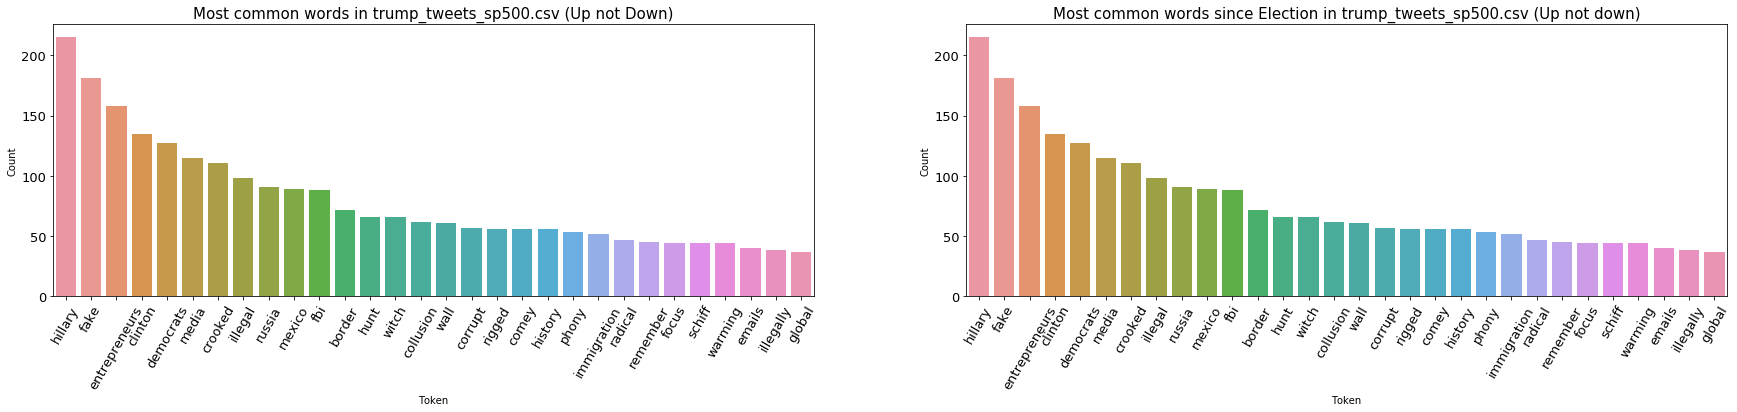

In [14]:
fig, ax = get_fig_ax(1, 2, 15, 5)
ax = top_n_tokens_plot_from_counter(up_not_down, 30, ax, 0, 0, "Most common words in {} (Up not Down)".format(file_name))
ax = top_n_tokens_plot_from_counter(up_not_down, 30, ax, 0, 1, "Most common words since Election in {} (Up not down)".format(file_name))

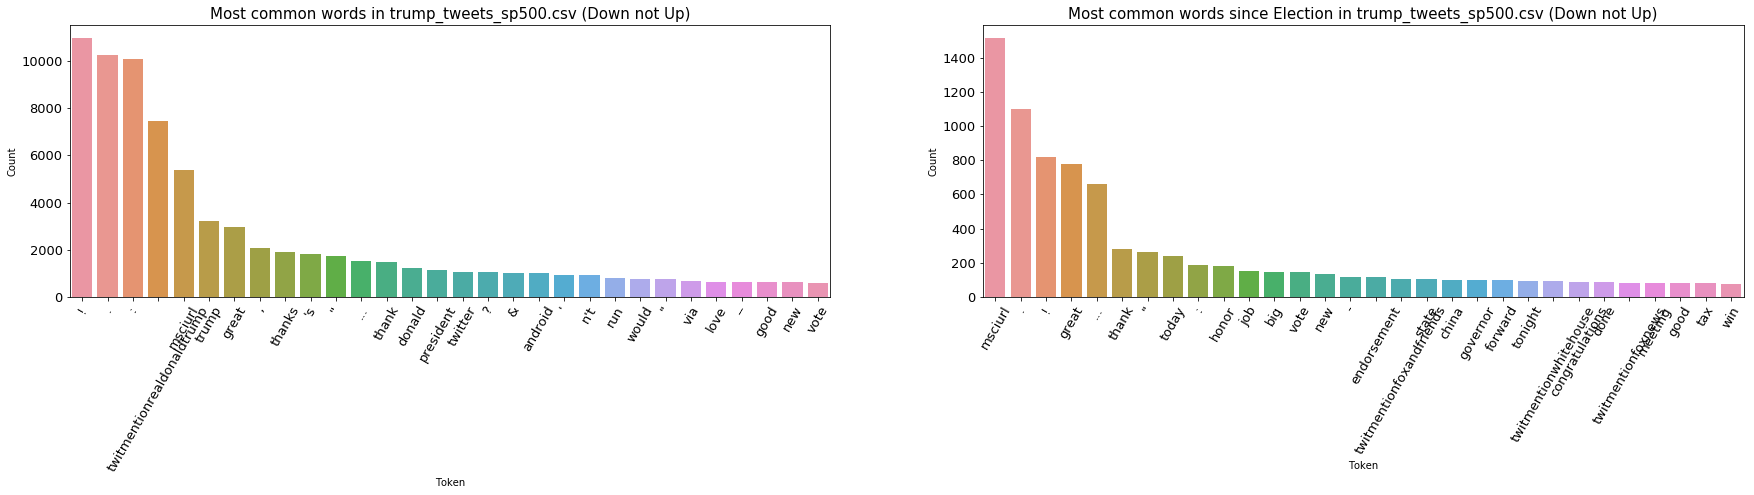

In [15]:
fig, ax = get_fig_ax(1, 2, 15, 5)
ax = top_n_tokens_plot_from_counter(down_not_up, 30, ax, 0, 0, "Most common words in {} (Down not Up)".format(file_name))
ax = top_n_tokens_plot_from_counter(down_not_up_since_election, 30, ax, 0, 1, "Most common words since Election in {} (Down not Up)".format(file_name))

# 3.0 Clustering for Common Topics

Summarize this but don't need to say much else

Ran out of memory trying to do this for all Trump tweets - I'm only going to do it for tweets since the election.  
Elbow method: https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

In [122]:
# Stealing stuff... http://brandonrose.org/clustering
from nltk.stem.snowball import SnowballStemmer
import nltk, re
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [123]:
stemmer = SnowballStemmer("english")

In [124]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
#     tokens = text.split(" ")
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token) or token == '...':
            filtered_tokens.append(stemmer.stem(token))
#         else:
#             filtered_tokens.append(token)
#     stems = [stemmer.stem(t) for t in filtered_tokens]
#     stems = [stemmer.stem(t) for t in text.split(" ")]
    return filtered_tokens

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return tokens

In [125]:
preprocessed_vocab = ' '.join(since_election['preprocessed_text'].tolist())
total_vocab = list(set(tokenize_only(preprocessed_vocab)))
total_vocab_stemmed = [stemmer.stem(t) for t in total_vocab]
vocab_frame = pd.DataFrame({'words': total_vocab}, index = total_vocab_stemmed)
print('there are ', str(vocab_frame.shape[0]), ' items in vocab_frame')

there are  14009  items in vocab_frame


In [126]:
# vocab_frame.head(10)

In [127]:
# vocab_frame.loc[['charact']].values.tolist()

In [128]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, use_idf=True, tokenizer=tokenize_only, ngram_range=(1,5))
count_vectorizer = CountVectorizer(max_df=0.8, min_df=5, tokenizer=tokenize_only, ngram_range=(1,5))
# , stop_words=stop_words.union({'msciurl'})

tfidf_matrix = tfidf_vectorizer.fit_transform(since_election["preprocessed_text"].tolist()) #fit the vectorizer to synopses
count_matrix = count_vectorizer.fit_transform(since_election['preprocessed_text'].tolist())

print("tfidf_matrix.shape: ", tfidf_matrix.shape)
print("count_matrix.shape: ", count_matrix.shape)

tfidf_matrix.shape:  (9329, 20050)
count_matrix.shape:  (9329, 20050)


In [129]:
# tf_idf_terms = tfidf_vectorizer.get_feature_names()

In [130]:
# tf_idf_terms[:10]

In [131]:
# count_terms = count_vectorizer.get_feature_names()

In [132]:
# count_terms[:10]

In [133]:
# from sklearn.cluster import KMeans
# def find_optimal_num_clusters(term_matrix, mat_name):
#     num_clusters=None
#     inertias = []
#     x_vals = [2, 4, 8] + list(range(10, 100, 10))
#     for i in x_vals:
#         print(i)
#         km = KMeans(n_clusters=i, max_iter=1000000, n_jobs=6, n_init=30)
#         km.fit(tfidf_matrix)
#         inertias.append(km.inertia_)
#     plt.plot(x_vals, inertias, 'bx-')
#     plt.xlabel('k')
#     plt.ylabel('Sum_of_squared_distances')
#     plt.title("Elbow Method For Optimal k - {}".format(mat_name))
#     plt.show()

In [134]:
# find_optimal_num_clusters(tfidf_matrix, 'TF-IDF')

2
4


KeyboardInterrupt: 

In [ ]:
# find_optimal_num_clusters(count_matrix, 'Counts')

In [ ]:
# # Best number of clusters (elbow method): 
# def kmeans_cluster_dataset(given_matrix, num_clusters):
#     km = KMeans(n_clusters=num_clusters, max_iter=1000000, n_jobs=4, n_init=30)
#     km.fit(given_matrix)
#     clusters = km.labels_.tolist()
#     print("Num Iter: ", km.n_iter_, "Inertia: ", km.inertia_)
#     return km, clusters

In [ ]:
# count_vectorizer = CountVectorizer(max_df=0.8, min_df=5, tokenizer=tokenize_only, ngram_range=(1,5))
# # , stop_words=stop_words.union({'msciurl'})

# # tfidf_matrix = tfidf_vectorizer.fit_transform(since_election["preprocessed_text"].tolist()) #fit the vectorizer to synopses
# count_matrix = count_vectorizer.fit_transform(since_election['preprocessed_text'].tolist())
# km_count, km_count_clusters = kmeans_cluster_dataset(count_matrix, 35)

In [ ]:
# clusters = km_count_clusters
# km = km_count
# num_clusters = 35

In [ ]:
# from sklearn.externals import joblib

# #uncomment the below to save your model 
# #since I've already run my model I am loading from the pickle

# joblib.dump(km,  'doc_cluster.pkl')

# km = joblib.load('doc_cluster.pkl')
# clusters = km.labels_.tolist()

In [ ]:
# since_election['cluster_number'] = clusters

In [ ]:
# since_election.head(10)

In [ ]:
# order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

# for i in range(num_clusters):
#     print("Cluster %d words: " % i, end='')
#     words_in_cluster = []
#     for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
#         words_in_cluster.extend(list(itertools.chain(*vocab_frame.loc[terms[ind].split(' ')].values.tolist())))
#     print(' '.join(set(words_in_cluster)))

## 3.1 Class Distribution of Clusters

In [37]:
# def show_distribution_of_clusters(start_clusters, end_clusters, fig, ax):
#     for i in range(start_clusters, end_clusters):
#         curr_cluster = since_election[since_election['cluster_number'] == i]
#         if not len(curr_cluster.index):
#             print("No Clusters at ", i)
#             continue
#         print(i, len(curr_cluster.index))
#         ax = visualize_class_distribution(curr_cluster["after_dir"], given_title="Stock directions after_dir for cluster {}".format(i), given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=0, col_idx=i-start_clusters)
#         ax = visualize_class_distribution(curr_cluster["1_open_dir"], given_title="Stock directions 1_open_dir for cluster {}".format(i), given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=1, col_idx=i-start_clusters)
# #         ax = visualize_class_distribution(curr_cluster["1_close_dir"], given_title="Stock directions 1_close_dir for cluster {}".format(i), given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=2, col_idx=i-start_clusters)
# #         ax = visualize_class_distribution(curr_cluster["2_open_dir"], given_title="Stock directions 2_open_dir for cluster {}".format(i), given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=3, col_idx=i-start_clusters)
# #         ax = visualize_class_distribution(curr_cluster["2_close_dir"], given_title="Stock directions 2_close_dir for cluster {}".format(i), given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=4, col_idx=i-start_clusters)
# #         ax = visualize_class_distribution(curr_cluster["eow_close_dir"], given_title="Stock directions eow_close_dir for cluster {}".format(i), given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=5, col_idx=i-start_clusters)
# #         ax = visualize_class_distribution(curr_cluster["sow_open_dir"], given_title="Stock directions sow_open_dir for cluster {}".format(i), given_label_titles={1: "Up", 0:"Down"}, axes=ax, row_idx=6, col_idx=i-start_clusters)

In [38]:
# for i in range(0, 50, 10):
#     fig, ax = get_fig_ax(7, 10, 5, 5)
#     show_distribution_of_clusters(i, i+10, fig, ax)
# # fig, ax = get_fig_ax(7, 10, 5, 5)
# # show_distribution_of_clusters(10, 20, fig, ax)
# # fig, ax = get_fig_ax(7, 10, 5, 5)
# # show_distribution_of_clusters(20, 30, fig, ax)

## 3.2 Examples in Clusters

In [39]:
# df = None
# sample_size=5
# for i in range(num_clusters):
#     curr_cluster = since_election[since_election['cluster_number'] == i]
#     if df is None:
#         df = curr_cluster.sample(n=min(sample_size, len(curr_cluster.index)-1))
#     else:
#         df = df.append(curr_cluster.sample(n=min(sample_size, len(curr_cluster.index)-1)))
#     df = df.append(pd.Series(), ignore_index=True)
# df[["text", "cluster_number"]]

# apriori

In [40]:
import re
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [41]:
def prep_fn(text):
    text = text.split(" ")
    final = []
    for word in text:
        if re.search('[a-zA-Z]', word) and word not in stop_words:
            final.append(word)
    return final

In [42]:
def apriori_with_df(given_df):
    dataset = list(map(prep_fn, given_df['preprocessed_text'].tolist()))
    oht = TransactionEncoder()
    oht_ary = oht.fit(dataset).transform(dataset)
    df = pd.DataFrame(oht_ary, columns=oht.columns_)
    frequent_itemsets = apriori(df, min_support=0.02, use_colnames=True)
    return frequent_itemsets

In [43]:
above_avg_apr = apriori_with_df(since_election[since_election[output_col] == 1]).values.tolist()
above_avg_apr_dict = {x[1]: x[0] for x in above_avg_apr if len(x[1]) > 1}
above_avg_apr_set = set([x[1] for x in above_avg_apr])

In [44]:
below_avg_apr = apriori_with_df(since_election[since_election[output_col] == 0]).values.tolist()
below_avg_apr_dict = {x[1]: x[0] for x in below_avg_apr if len(x[1]) > 1}
below_avg_apr_set = set([x[1] for x in below_avg_apr])

In [45]:
below_avg_apr_dict

{frozenset({'great', 'honor', 'msciurl'}): 0.02132701421800948,
 frozenset({'msciurl', 'thank'}): 0.05614290922347794,
 frozenset({'america', 'msciurl'}): 0.025519504192489974,
 frozenset({'great', 'thank'}): 0.027706890266131972,
 frozenset({'house', 'white'}): 0.02023332118118848,
 frozenset({'great', 'honor'}): 0.023332118118847976,
 frozenset({'msciurl', 'today'}): 0.037732409770324465,
 frozenset({'great', 'msciurl'}): 0.07874589865111192,
 frozenset({'great', 'people'}): 0.027342325920524973,
 frozenset({'fake', 'news'}): 0.037550127597520966,
 frozenset({'honor', 'msciurl'}): 0.03335763762304047,
 frozenset({'states', 'united'}): 0.028982865475756472,
 frozenset({'great', 'job'}): 0.02825373678454247,
 frozenset({'big', 'great'}): 0.02150929639081298,
 frozenset({'great', 'state'}): 0.024790375501275976,
 frozenset({'america', 'great'}): 0.024243528982865477,
 frozenset({'president', 'trump'}): 0.02005103900838498,
 frozenset({'great', 'today'}): 0.026248632883703972}

In [46]:
above_avg_apr_diff = Counter(above_avg_apr_dict) - Counter(below_avg_apr_dict)

In [47]:
below_avg_apr_diff = Counter(below_avg_apr_dict) - Counter(above_avg_apr_dict)

In [48]:
below_avg_apr_diff.items()

dict_items([(frozenset({'thank', 'msciurl'}), 0.03168285197653545), (frozenset({'america', 'msciurl'}), 0.025519504192489974), (frozenset({'great', 'big'}), 0.02150929639081298), (frozenset({'great', 'thank'}), 0.027706890266131972), (frozenset({'house', 'white'}), 0.02023332118118848), (frozenset({'msciurl', 'today'}), 0.037732409770324465), (frozenset({'great', 'honor', 'msciurl'}), 0.02132701421800948), (frozenset({'great', 'honor'}), 0.023332118118847976), (frozenset({'honor', 'msciurl'}), 0.03335763762304047), (frozenset({'great', 'job'}), 0.02825373678454247), (frozenset({'great', 'msciurl'}), 0.055586908279006794), (frozenset({'state', 'great'}), 0.024790375501275976), (frozenset({'president', 'trump'}), 0.02005103900838498), (frozenset({'great', 'today'}), 0.026248632883703972)])

In [49]:
above_avg_apr_feats = sorted([x for x in above_avg_apr_diff.most_common(4) if x[1] > 0.04], key=lambda x: x[1], reverse=True)
below_avg_apr_feats = sorted([x for x in below_avg_apr_diff.most_common(4) if x[1] > 0.04], key=lambda x: x[1], reverse=True)

In [50]:
above_avg_apr_feats

[(frozenset({'fake', 'news'}), 0.052483700141224804),
 (frozenset({'fake', 'media'}), 0.04553734061930783),
 (frozenset({'hunt', 'witch'}), 0.04449648711943794),
 (frozenset({'media', 'news'}), 0.04267499349466563)]

In [51]:
# feat = above_avg_apr_feats[0]

In [52]:
def contains_feature(tweets, feat):
    contains_feat_list = []
    for tweet in tweets:
        curr_set = [1 if word in set(tweet) else 0 for word in feat]
#         print(feat, curr_set)
#         print(ting)
        contains_feat_list.append(min(curr_set))
    return contains_feat_list

In [53]:
tweets = list(map(lambda x: x.split(" "), since_election['preprocessed_text'].tolist()))

In [54]:
for feat in above_avg_apr_feats:
    col_name = "above_avg_apr_{}".format('_'.join(feat[0]))
    since_election[col_name] = contains_feature(tweets, feat[0])
    since_election[col_name] = since_election[col_name].astype('category')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [55]:
for feat in below_avg_apr_feats:
    col_name = "below_avg_apr_{}".format('_'.join(feat[0]))
    since_election[col_name] = contains_feature(tweets, feat[0])
    since_election[col_name] = since_election[col_name].astype('category')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [56]:
since_election.columns

Index(['text', 'created_at', 'retweet_count', 'favorite_count', 'is_retweet',
       'after_dir', '1_open_dir', '1_close_dir', '2_open_dir', '2_close_dir',
       'eow_close_dir', 'sow_open_dir', 'sig_up', 'sig_down', 'is_sig',
       'preprocessed_text', 'created_hour', 'dow', 'num_links', 'num_words',
       'above_monthly_avg', 'above_avg_apr_fake_news',
       'above_avg_apr_fake_media', 'above_avg_apr_witch_hunt',
       'above_avg_apr_media_news', 'below_avg_apr_great_msciurl'],
      dtype='object')

## 3.3 LDA for Topic Clustering - SKIPPING FOR NOW, SINCE IT'S NOT TECHNICALLY PART OF THE REPORT

This section focuses on using Latent Dirichlet Allocation (LDA) to learn yet more about the hidden structure within the top 100 film synopses. LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics. There is quite a good high-level overview of probabilistic topic models by one of the big names in the field, David Blei, available in the Communications of the ACM here. Incidentally, Blei was one of the authors of the seminal paper on LDA.
https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

HAD TO ADD THE WORD "GREAT" TO THE STOPWORD LIST BECAUSE IT WAS IN LITERALLY EVERY CLUSTER...

In [108]:
# Remove proper nouns (in this case get rid of all mentions)
since_election['preprocessed_no_mentions'] = since_election['preprocessed_text'].apply(lambda tweet: ' '.join([w for w in tweet.split(' ') if 'twitmention' not in w and w not in stop_words.union({'msciurl', 'great'}) and re.search('[a-zA-Z]', w)]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [109]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora, models, similarities 

In [110]:
texts = [[ting for ting in x.split(" ") if ting != ''] for x in since_election['preprocessed_no_mentions'].tolist()]
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.99)
# 0.21

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [111]:
coherence_scores = []
for i in range(2, 50, 2):
    lda = models.LdaMulticore(corpus, num_topics=i, 
                                id2word=dictionary, iterations=500)
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

In [112]:
# coherence_scores

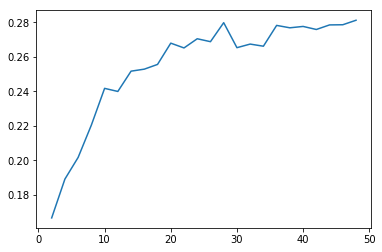

In [113]:
plt.plot([x for x in range(2, 50, 2)], coherence_scores)

In [114]:
lda_num_topics = 44

In [115]:

lda = models.LdaMulticore(corpus, num_topics=lda_num_topics, iterations=500,
                                id2word=dictionary)

In [116]:
lda.show_topics(num_topics=lda_num_topics)

[(0,
  '0.008*"trump" + 0.007*"big" + 0.007*"people" + 0.007*"one" + 0.006*"america" + 0.006*"make" + 0.005*"many" + 0.005*"thank" + 0.005*"new" + 0.005*"get"'),
 (1,
  '0.009*"people" + 0.008*"president" + 0.007*"united" + 0.006*"many" + 0.006*"democrats" + 0.006*"much" + 0.006*"states" + 0.006*"china" + 0.005*"state" + 0.005*"years"'),
 (2,
  '0.012*"president" + 0.008*"america" + 0.008*"news" + 0.007*"fake" + 0.006*"u.s." + 0.006*"trump" + 0.005*"make" + 0.005*"never" + 0.005*"going" + 0.005*"got"'),
 (3,
  '0.009*"thank" + 0.006*"many" + 0.006*"much" + 0.006*"china" + 0.005*"country" + 0.005*"u.s." + 0.005*"democrats" + 0.004*"news" + 0.004*"united" + 0.004*"tonight"'),
 (4,
  '0.008*"border" + 0.007*"democrats" + 0.007*"want" + 0.007*"people" + 0.006*"deal" + 0.006*"president" + 0.006*"many" + 0.006*"u.s." + 0.005*"must" + 0.005*"china"'),
 (5,
  '0.013*"today" + 0.011*"president" + 0.009*"many" + 0.007*"people" + 0.007*"country" + 0.006*"get" + 0.005*"good" + 0.005*"deal" + 0.005

- The area of circle represents the importance of each topic over the entire corpus
- The distance between the center of circles indicate the similarity between topics.
- Indices = sorted order by area
- Blue = overall term frequency
- Red = term freq within selected topic
- Lambda: trying to strike a balance between choosing general vs specific words (lambda=0 means super specific - exclusively popular for this topic)
- If some topics contain general words/feelings/sentiments

In [117]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [118]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# df_dominant_topic.head(10)
df_dominant_topic['preprocessed_text'] = since_election['preprocessed_text'].tolist()

In [119]:
# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda.show_topics(num_topics=lda_num_topics, formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

# print(lda.show_topics(num_topics=lda_num_topics, formatted=False))

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(' '.join)
df_top3words.reset_index(level=0,inplace=True)
df_top3words

,topic_id,words
0,0,trump big people
1,1,people president united
2,2,president america news
3,3,thank many much
4,4,border democrats want
5,5,today president many
6,6,deal u.s. china
7,7,president news china
8,8,democrats states united
9,9,people get news


In [120]:
df = None
sample_size=5
for i in range(lda_num_topics):
    curr_cluster = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == i].sort_values(by='Topic_Perc_Contrib', ascending=False)
    if df is None:
        df = curr_cluster.head(sample_size)#.sample(n=min(sample_size, len(curr_cluster.index)-1))
    else:
        df = df.append(curr_cluster.head(sample_size))#curr_cluster.sample(n=min(sample_size, len(curr_cluster.index)-1)))
    df = df.append(pd.Series(), ignore_index=True)
df[["preprocessed_text", "Dominant_Topic", 'Topic_Perc_Contrib']]

,preprocessed_text,Dominant_Topic,Topic_Perc_Contrib
0,""" conflict between glen simpson ' s testimony to another house panel about his contact with justice department official bruce ohr . ohr was used by simpson and steele as a back channel to get ( fake ) dossier to fbi . simpson pleading fifth. "" catherine herridge . where is jeff sessions ?",0.0,0.9685
1,""" face it you probably got a tax cut ! "" this was a new york times headline and it is very true . if republicans take back the house and keep the senate and presidency one of our first acts will be to approve a major middle income tax cut ! democrats only want to raise your taxes !",0.0,0.9685
2,in the beautiful midwest windchill temperatures are reaching minus 60 degrees the coldest ever recorded . in coming days expected to get even colder . people can ' t last outside even for minutes . what the hell is going on with global waming ? please come back fast we need you !,0.0,0.9685
3,big rally tonight in west virginia . patrick morrisey is running a great race for u.s. senate . i have done so much for west virginia against all odds and having patrick a real fighter by my side would make things so much easier . see you later . clean coal ! ! ! !,0.0,0.9663
4,... .in our country ' s history and the poverty index is also best number ever ) leagues and teams love coming to the white house . i am a big fan of the american team and women ' s soccer but megan should win first before she talks ! finish the job ! we haven ' t yet ... .,0.0,0.9663
5,NaN,NaN,NaN
6,starting at a small bible school in florida billy graham soon led a nationwide revival . from a large tent in los angeles to one hundred thousand people in a single day at yankee stadium to more than two million people at madison square garden over sixteen weeks in 1957 ... msciurl,1.0,0.9694
7,... .employment numbers ever low taxes & regulations a rebuilt military & v.a . many great new judges & so much more . but we have had a giant scam perpetrated upon our nation a witch hunt a treasonous hoax . that is the constitutional crisis & hopefully guilty people will pay !,1.0,0.9663
8,can ' t let brett kavanaugh give radical left democrat ( liberal plus ) opinions based on threats of impeaching him over made up stories ( sound familiar ? ) false allegations and lies . this is the game they play . fake and corrupt news is working overtime ! twithashtagprotectkavanaugh,1.0,0.9663
9,... ..came from and in far safer conditions . no matter how good things actually look even if perfect the democrat visitors will act shocked & aghast at how terrible things are . just pols . if they really want to fix them change the immigration laws and loopholes . so easy to do !,1.0,0.9651


In [136]:
# lda.save('44_clusters_removed_great_lda.model')

In [135]:
# df.to_csv('lda_44_clusters_removed_great.csv', index=False)

In [121]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary=lda.id2word)
vis

/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
30     3.399625  1        1      -0.016551  0.005427
24     3.243422  1        2       0.019274  0.001528
28     3.202643  1        3      -0.026387 -0.005470
21     3.049005  1        4      -0.016502  0.015302
12     2.991037  1        5       0.058094  0.003150
32     2.947301  1        6       0.036618  0.001540
8      2.793026  1        7       0.035101 -0.004376
37     2.647929  1        8      -0.025261 -0.034930
18     2.618268  1        9      -0.000116  0.001923
29     2.604947  1        10     -0.002367 -0.009873
41     2.540883  1        11     -0.000138  0.011476
27     2.538341  1        12     -0.029364 -0.036567
5      2.524983  1        13     -0.004921  0.014164
42     2.491232  1        14      0.005475  0.019637
26     2.429241  1        15      0.004953 -0.008663
22     2.420046  1        16     -0.060336 -0.001371
1      2.402058  1        17     -0.000756 -0.012552
13     2.322320  1        18      0.001500  0.005623
19     2.301480  1        19      0.014542  0.022190
10     2.246118  1        20      0.057646  0.013204
34     2.238119  1        21      0.015829  0.012665
43     2.214328  1        22     -0.044239 -0.060321
11     2.189366  1        23      0.008272  0.011053
33     2.176351  1        24     -0.109291 -0.032263
40     2.175684  1        25      0.080547  0.012433
20     2.160994  1        26      0.038753  0.030375
16     2.137669  1        27      0.007241  0.015282
7      2.121786  1        28     -0.046703  0.039831
3      2.060914  1        29      0.007800  0.036920
23     2.046053  1        30     -0.055770  0.015733
4      2.010430  1        31      0.049812  0.039053
38     1.976752  1        32      0.000279 -0.031537
6      1.906662  1        33     -0.026145  0.054725
9      1.886226  1        34     -0.008648  0.008344
39     1.870198  1        35     -0.031421 -0.068768
0      1.868109  1        36      0.024162 -0.013201
14     1.857912  1        37      0.068253 -0.022336
2      1.814146  1        38     -0.038243  0.026152
25     1.805277  1        39      0.021368 -0.022161
36     1.728660  1        40      0.033338  0.047478
15     1.610499  1        41      0.012257 -0.029082
17     1.589369  1        42     -0.003089 -0.108408
35     1.428457  1        43     -0.079765  0.106549
31     1.412141  1        44      0.024898 -0.069880, topic_info=      Category        Freq                        Term       Total  loglift  \
9332   Default  430.000000  china                       430.000000  30.0000   
7513   Default  644.000000  fake                        644.000000  29.0000   
10941  Default  443.000000  media                       443.000000  28.0000   
57     Default  589.000000  trump                       589.000000  27.0000   
1309   Default  833.000000  president                   833.000000  26.0000   
8093   Default  520.000000  thank                       520.000000  25.0000   
5837   Default  709.000000  news                        709.000000  24.0000   
10620  Default  294.000000  vote                        294.000000  23.0000   
1284   Default  253.000000  jobs                        253.000000  22.0000   
11452  Default  540.000000  border                      540.000000  21.0000   
9573   Default  235.000000  russia                      235.000000  20.0000   
8295   Default  240.000000  mueller                     240.000000  19.0000   
12381  Default  994.000000  people                      994.000000  18.0000   
8955   Default  173.000000  korea                       173.000000  17.0000   
10710  Default  154.000000  clinton                     154.000000  16.0000   
1154   Default  353.000000  make                        353.000000  15.0000   
625    Default  432.000000  america                     432.000000  14.0000   
10443  Default  226.000000  north                       226.000000  13.0000   
6395   Default  45

In [78]:
# since_election.head(10)

# 4.0 Distributions

## 4.1.1 Time of Day (Up vs Down)

In [ ]:
from data_science_toolkit.data_visualization import generate_histogram
fig, ax = get_fig_ax(2, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["created_hour"], ax, 0, 0, "Hour of Day", "Tweets (%)", "Number of Tweets vs. Time of Day (Up)", True, show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["created_hour"], ax, 0, 1, "Hour of Day", "Tweets (%)", "Number of Tweets vs. Time of Day Since Election (Up)", True, show_sd=False, show_best_fit=False)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["created_hour"], ax, 1, 0, "Hour of Day", "Tweets (%)", "Number of Tweets vs. Time of Day (Down)", True, show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["created_hour"], ax, 1, 1, "Hour of Day", "Tweets (%)", "Number of Tweets vs. Time of Day Since Election (Down)", True, show_sd=False, show_best_fit=False)

## 4.2.1 Day of Week (Up vs Down)

In [ ]:
fig, ax = get_fig_ax(2, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["dow"], ax, 0, 0, "Day of Week", "Tweets (%)", "Number of Tweets vs. Day of Week (Up)", True, show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["dow"], ax, 0, 1, "Day of Week", "Tweets (%)", "Number of Tweets vs. Day of Week Since Election (Up)", True, show_sd=False, show_best_fit=False)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["dow"], ax, 1, 0, "Day of Week", "Tweets (%)", "Number of Tweets vs. Day of Week (Down)", True, show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["dow"], ax, 1, 1, "Day of Week", "Tweets (%)", "Number of Tweets vs. Day of Week Since Election (Down)", True, show_sd=False, show_best_fit=False)

## 4.3.1 Num Retweets (Up vs Down)

In [ ]:
# def cdf(x, plot=True, *args, **kwargs):
#     x, y = sorted(x), np.arange(len(x)) / len(x)
#     return plt.plot(x, y, *args, **kwargs) if plot else (x, y)

In [ ]:
# ax = cdf(since_election[(since_election["after_dir"] == 1)]["retweet_count"].tolist())

In [ ]:
# bin_list = [[0, 500], [500, 1000]] + [[x, x+1000] for x in range(1000, 50000, 1000)] + [[50000, 100000], [100000, float("inf")]]

In [ ]:
# fig, ax = get_fig_ax(2, 2, 20, 8)

# ax = generate_histogram(stock_tweet[stock_tweet["after_dir"] == 1]["retweet_count"], ax, 0, 0, 
#                         "Num Retweets", "Tweets (%)", "Number of Tweets vs. Num RT (Up)", True, 
#                         bins=bin_list, show_sd=False, show_best_fit=False)
# ax = generate_histogram(since_election[since_election["after_dir"] == 1]["retweet_count"], ax, 0, 1, 
#                         "Num Retweets", "Tweets (%)", "Number of Tweets vs. Num RT Since Election (Up)", True, 
#                         bins=bin_list, show_sd=False, show_best_fit=False)
# ax = generate_histogram(stock_tweet[stock_tweet["after_dir"] == 0]["retweet_count"], ax, 1, 0, 
#                         "Num RT", "Tweets (%)", "Number of Tweets vs. Num RT (Down)", True, 
#                         bins=bin_list, show_sd=False, show_best_fit=False)
# ax = generate_histogram(since_election[since_election["after_dir"] == 0]["retweet_count"], ax, 1, 1, 
#                         "Num RT", "Tweets (%)", "Number of Tweets vs. Num RT Since Election (Down)", True, 
#                         bins=bin_list, show_sd=False, show_best_fit=False)

## 4.4.1 Num Favorites (Up vs Down)

In [ ]:
# ax = cdf(since_election[(since_election["after_dir"] == 1) & (since_election['is_retweet'] == False)]["favorite_count"].tolist())

In [ ]:
# def histedges_equalN(x, nbin):
#     npt = len(x)
#     return np.interp(np.linspace(0, npt, nbin + 1),
#                      np.arange(npt),
#                      np.sort(x))

# x = since_election[(since_election["after_dir"] == 1) & (since_election['is_retweet'] == False)]["favorite_count"].tolist()
# n, bins, patches = plt.hist(x, histedges_equalN(x, 10), density=True)

In [ ]:
# x = since_election[(since_election["after_dir"] == 0) & (since_election['is_retweet'] == False)]["favorite_count"].tolist()
# n, bins, patches = plt.hist(x, histedges_equalN(x, 10), density=True)

In [ ]:
# bin_list = [[0, 100], [100, 10000]] + [[x, x+10000] for x in range(1000, 200000, 10000)] + [[200000, 400000], [400000, float("inf")]]

In [ ]:
# fig, ax = get_fig_ax(2, 2, 20, 8)

# ax = generate_histogram(stock_tweet[stock_tweet["after_dir"] == 1]["favorite_count"], ax, 0, 0, 
#                         "Num Retweets", "Tweets (%)", "Number of Tweets vs. Num RT (Up)", True, 
#                         bins=bin_list, show_sd=False, show_best_fit=False)
# ax = generate_histogram(since_election[since_election["after_dir"] == 1]["favorite_count"], ax, 0, 1, 
#                         "Num Retweets", "Tweets (%)", "Number of Tweets vs. Num RT Since Election (Up)", True, 
#                         bins=bin_list, show_sd=False, show_best_fit=False)
# ax = generate_histogram(stock_tweet[stock_tweet["after_dir"] == 0]["favorite_count"], ax, 1, 0, 
#                         "Num RT", "Tweets (%)", "Number of Tweets vs. Num RT (Down)", True, 
#                         bins=bin_list, show_sd=False, show_best_fit=False)
# ax = generate_histogram(since_election[since_election["after_dir"] == 0]["favorite_count"], ax, 1, 1, 
#                         "Num RT", "Tweets (%)", "Number of Tweets vs. Num RT Since Election (Down)", True, 
#                         bins=bin_list, show_sd=False, show_best_fit=False)

## 5.1 Tweet Anatomy

In [ ]:
# ax = cdf(since_election[(since_election["after_dir"] == 1) & (since_election['is_retweet'] == False)]["favorite_count"].tolist())

In [ ]:
fig, ax = get_fig_ax(2, 2, 20, 8)

ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_words"], ax, 0, 0, 
                        "Num Retweets", "Tweets (%)", "Number of Tweets vs. Num RT (Up)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_words"], ax, 0, 1, 
                        "Num Retweets", "Tweets (%)", "Number of Tweets vs. Num RT Since Election (Up)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_words"], ax, 1, 0, 
                        "Num RT", "Tweets (%)", "Number of Tweets vs. Num RT (Down)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_words"], ax, 1, 1, 
                        "Num RT", "Tweets (%)", "Number of Tweets vs. Num RT Since Election (Down)", True, 
                        show_sd=False, show_best_fit=False)

In [ ]:
since_election[since_election.num_words > 55]

In [ ]:
fig, ax = get_fig_ax(2, 2, 20, 8)

ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_links"], ax, 0, 0, 
                        "Num Retweets", "Tweets (%)", "Number of Tweets vs. Num RT (Up)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_links"], ax, 0, 1, 
                        "Num Retweets", "Tweets (%)", "Number of Tweets vs. Num RT Since Election (Up)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_links"], ax, 1, 0, 
                        "Num RT", "Tweets (%)", "Number of Tweets vs. Num RT (Down)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_links"], ax, 1, 1, 
                        "Num RT", "Tweets (%)", "Number of Tweets vs. Num RT Since Election (Down)", True, 
                        show_sd=False, show_best_fit=False)

In [ ]:
stock_tweet.head(10)

In [ ]:
since_election.head(10)

## This is what we will be using for models...

In [ ]:
since_election.to_csv('./since_election_with_cluster_{}'.format(file_name), index=False)

# Conclusions